# Changing sensitivity of machine learning algorithms and performing a receiver-operator characteristic curve

With machine learning we may want to change the sensitivity of an algorithm such that a high or lower threshold would be necessary to classify some data as 'positive'. For example, in cancer screening it may be judged to preferable to err towards classifying someone as 'possible cancer' rather than 'probable not cancer' to ensure as few people with cancer are missed by the screen. As we increase the sensitivity in this way we will miss fewer real positives, but at the cost of generating more false positives (those without cancer who are classified as 'possible cancer'). 

Rather than taking a predicted classification output we take a probability estimate output that is balanced between two classes.  For example the output may be 0.61 for class 1 (no cancer) and 0.39 for class 2 (cancer). Ordinarily the model will classify this patient as ‘no cancer’. But we may set our threshold for classification of cancer at 0.3 for the cancer class, in which case this same patient will be classified as ‘cancer’. That means any classification that has at least a 30% probability of being cancer is classified as cancer.

In order to change the sensitivity of the model we train the model as usual, but instead of using .predict to obtain classification, we use .predict_proba. For each patient this will return the probabilities of being either ‘no cancer’ or ‘cancer’. We compare the outputted probability of being cancer with our desired threshold.

A ‘receiver operating characteristic (ROC) curve’ is a common way of displaying the trade-off between identifying all true positives, and incorrectly labelling a person as a positive (that they have cancer, for example) when they do not.

ROC curve plots two measures:

* False positive rate (on the x axis): This is the proportion of real negatives (no cancer) that are mistakenly classified as positive (cancer).

* True positive rate (y axis): This is the proportion of true positives (cancer) correctly identified as positive. 

Ideally we want to identify all true positives with no false positives.

In the code below we will train the model, and we will will adjust the threshold of classification in a loop. In order to get the best quality results we will use k-fold stratification to run the model 10 times, with each sample being used once and only as a test sample (rather than training sample). The ‘stratified’ form of the k-fold method ensures that all training/test splits have a consistent split between cancer and non-cancer patients (being representative of the data set as a whole). Please see lesson 75 for more details on the k-fold stratification method.

We will use a linear regression model. Note that some other machine learning models, will output their probability classification with .decision_function rather than .predict_proba. Here are the methods for probability output for the common ml methods in sckit learn.

* Logistic regression:  predict_proba
* Random Forests:  predict_proba
* Support Vector Machines:  decision_function
* Neural Networks (mlp):  predict_proba

Let's look at some code. In order to demonstrate the trade off we'll use the Winsonsin Breast Cancer data set, but we will make it much harder for the model to be accurate by only using the first two features from each patient.

Scikit learn has some automated methods for ROC production, but here we will do it 'manually' to see what is happening.

For more on ROC curves see https://en.wikipedia.org/wiki/Receiver_operating_characteristic

We'll start by loading modules that will used throughout the code: 

In [1]:
import numpy as np
import pandas as pd

Now we will define the function to load the data. Remember we are deliberately only using two features per patient here the make the trade-off in sensitivity of the algoirthm clearer. You would not normally do this!

In [2]:
def load_data():
    """Load data from appropriate source. Here we load data from scikit
    learn's buil in data sets, but we restrict the feature data to two columns
    in order to demonstrate changing sensitivity of the model"""
    
    from sklearn import datasets
    
    data_set = datasets.load_breast_cancer()
    X=data_set.data[:,0:2]
    y=data_set.target
    return X, y

Now we will define the function to normalise the data.

In [3]:
def normalise (X_train,X_test):
    """Normalise X data, so that training set has mean of zero and standard
    deviation of one"""
    
    from sklearn.preprocessing import StandardScaler
    # Initialise a new scaling object for normalising input data
    sc=StandardScaler() 
    # Set up the scaler just on the training set
    sc.fit(X_train)
    # Apply the scaler to the training and test sets
    X_train_std=sc.transform(X_train)
    X_test_std=sc.transform(X_test)
    
    # Return normalised data
    return X_train_std, X_test_std

Next wi will define the function that will provide us with 'k' (which we will later set to 10) different training/test splits so that each sample is used once and only once as a test sample.

In [4]:
def set_up_k_fold_splits(k):
    """Set up K-fold splits. This will divide data into k sets such that each
    data points is used once and only once in the test set. Each test/training
    split has same balance of y (the classified outcome) as the whole data
    set"""
    
    from sklearn.model_selection import StratifiedKFold
    
    skf = StratifiedKFold(n_splits = k)
    skf.get_n_splits(X, y)

    return skf

Here is the function that will train the model.

In [5]:
def train_model (X, y):
    """Train the model """
    
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(C=100,random_state=0)
    model.fit(X, y)
    
    return model

And here is the function that classifies test samples with a given threshold level (which can be anywhere between zero and one). We will put that threshold level in a loop and call this function with different threshold levels.

In [6]:
def test_model (model, X_test_std, y, threshold):
    y_pred_probability = model.predict_proba(X_test_std)
    # Check probability of positive classification is >trhreshold
    y_pred = (y_pred_probability[:,1] >= threshold)
    # Convert boolean to 0/1 (could also simply multiple by 1)
    y_pred = y_pred.astype(int)
    
    test_results = np.vstack((y, y_pred)).T
    
    # return results
    return test_results

Though we will be using just false positive and true positive rates, for reference we'll report back a full list of performance metrics.

In [7]:
def calculate_diagnostic_performance (actual_predicted):
    """ Calculate diagnostic performance.
    
    Takes a Numpy array of 1 and zero, two columns: actual and predicted
    
    Note that some statistics are repeats with different names
    (precision = positive_predictive_value and recall = sensitivity).
    Both names are returned
    
    Returns a dictionary of results:
        
    1) accuracy: proportion of test results that are correct    
    2) sensitivity: proportion of true +ve identified
    3) specificity: proportion of true -ve identified
    4) positive likelihood: increased probability of true +ve if test +ve
    5) negative likelihood: reduced probability of true +ve if test -ve
    6) true positive rate: proportion of test +ve that are positive
    6) false positive rate: proportion of false +ves in true -ve patients
    7) false negative rate:  proportion of false -ves in true +ve patients
    8) positive predictive value: chance of true +ve if test +ve
    9) negative predictive value: chance of true -ve if test -ve
    10) precision = positive predictive value 
    11) recall = sensitivity
    12) f1 = (2 * precision * recall) / (precision + recall)
    13) positive rate = rate of true +ve (not strictly a performance measure)
    """
    # Calculate results
    actual_positives = actual_predicted[:, 0] == 1
    actual_negatives = actual_predicted[:, 0] == 0
    test_positives = actual_predicted[:, 1] == 1
    test_negatives = actual_predicted[:, 1] == 0
    test_correct = actual_predicted[:, 0] == actual_predicted[:, 1]
    accuracy = np.average(test_correct)
    true_positives = actual_positives & test_positives
    false_positives = test_positives & actual_negatives
    false_negatives = test_negatives & actual_positives
    true_negatives = actual_negatives & test_negatives
    sensitivity = np.sum(true_positives) / np.sum(actual_positives)
    specificity = np.sum(true_negatives) / np.sum(actual_negatives)
    positive_likelihood = sensitivity / (1 - specificity)
    negative_likelihood = (1 - sensitivity) / specificity
    true_positive_rate = sensitivity
    false_positive_rate = 1 - specificity
    false_negative_rate = np.sum(false_negatives) / np.sum(test_negatives)
    positive_predictive_value = np.sum(true_positives) / np.sum(test_positives)
    negative_predictive_value = np.sum(true_negatives) / np.sum(test_negatives)
    precision = positive_predictive_value
    recall = sensitivity
    f1 = (2 * precision * recall) / (precision + recall)
    positive_rate = np.mean(actual_predicted[:,1])
    
    # Add results to dictionary
    performance = {}
    performance['accuracy'] = accuracy
    performance['sensitivity'] = sensitivity
    performance['specificity'] = specificity
    performance['positive_likelihood'] = positive_likelihood
    performance['negative_likelihood'] = negative_likelihood
    performance['true_positive_rate'] = true_positive_rate
    performance['false_positive_rate'] = false_positive_rate
    performance['false_negative_rate'] = false_negative_rate
    performance['positive_predictive_value'] = positive_predictive_value
    performance['negative_predictive_value'] = negative_predictive_value
    performance['precision'] = precision
    performance['recall'] = recall
    performance['f1'] = f1
    performance['positive_rate'] = positive_rate

    # Return results dictionary
    return performance

We can also calulate the area under the curve of the ROC curve. For a perfect classification this would equal 1.0. If the model is no better, but no worse, than chance then area under curve would be zero. For a model that is worse than chance the area under curve would be less than 0.5. We use the NumPy trapz method to calculate area under curve which is a suitable method when we are determining the ROC curve in high detail as we are here (we will have 100 points on the ROC curve).

In [8]:
def calculate_area_under_roc (true_positive_rate, false_positive_rate):
    auc = np.trapz(true_positive_rate, x=false_positive_rate)
    return auc

We will record all results in a Pandas dataframe. Here we set it up.

In [9]:
def set_up_results_dataframe():
    cols = ['threshold',
            'k_fold',
            'accuracy',
            'sensitivity',
            'specificity',
            'positive_likelihood',
            'negative_likelihood',
            'true_positive_rate',
            'false_positive_rate',
            'false_negative_rate',
            'positive_predictive_value',
            'negative_predictive_value',
            'precision',
            'recall',
            'f1',
            'positive_rate']
    
    df = pd.DataFrame(columns = cols)
    
    return df

We will have a function to plot the ROC curve.

In [10]:
def plot_roc(false_positive_rate, true_positive_rate):
    """Plot receiver operator curve."""
    
    %matplotlib inline
    
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    

    x = false_positive_rate
    y = true_positive_rate
    
    # Define the size of the overall figure
    fig = plt.figure(figsize=(5,5)) 

    # Create subplot 1

    ax1 = fig.add_subplot(111) # Grid of 2x2, this is suplot 1
    
    # Plot mran results
    ax1.plot(x, y, color = 'k')
    
    ax1.set_xlabel('False positive rate')
    ax1.set_ylabel('True positive rate rate')
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    ax1.grid(True, which='both')
    
    plt.savefig('roc.png',dpi=300)
    plt.show()
    
    return

And now we will call those functions in the main code.

/home/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/home/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in long_scalars
/home/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in long_scalars
/home/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in double_scalars
/home/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars
/home/michael/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in long_scalars


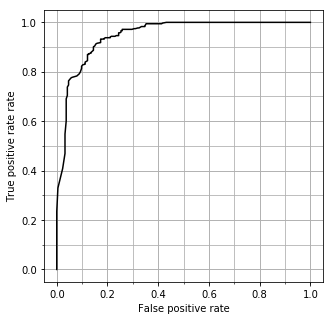

Area under curve mean = 0.956
Area under curve stdev = 0.020


In [11]:
# Load data
X, y = load_data()

# Set up K-fold splits. 
splits = 10
skf = set_up_k_fold_splits (splits)

# Set up results dataframe

results_df = set_up_results_dataframe()

# Set up counters (used in the results record)

run_id = 0
k_fold_count = 0

# Loop through k-fold training/test splits

for train_index, test_index in skf.split(X, y):
    
    # Divide data in train and test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Normalise data
    X_train_std, X_test_std = normalise(X_train,X_test)

    # Train model
    model = train_model (X_train_std,y_train)
    
    # Loop through a range of thresholds when predicting classification
    for threshold in np.arange (0.0,1.01,0.01):
        # linear regression model has .predict+proba  method to return 
        # probability of outcomes. Some methods such as svc use 
        # .decision_function to return probability
        
        # Get test results (combined with actual classification)
        test_results = test_model (model, X_test_std, y_test, threshold)
        
        # Measure performance of test set predictions
        performance = calculate_diagnostic_performance(test_results)
        run_results = [threshold, k_fold_count] + list(performance.values())
        results_df.loc[run_id] = run_results
        run_id += 1
    
    k_fold_count += 1 # increment counter of k-fold

# Summarise performance data
summary_mean = results_df.groupby('threshold').mean()
summary_stdev = results_df.groupby('threshold').std()

# Call for ROC to be plotted 
plot_roc (summary_mean['false_positive_rate'],
          summary_mean['true_positive_rate'])
    
# Calculate area under curve for each k-fold
area_under_curve_per_run = []
for split in range(splits):
    mask = results_df['k_fold'] == split
    run_data = results_df[mask]
    run_data = run_data.sort_values(['false_positive_rate'])
    true_positive_rate = run_data['true_positive_rate'].values
    false_positive_rate = run_data['false_positive_rate'].values
    auc = calculate_area_under_roc(true_positive_rate, false_positive_rate)
    area_under_curve_per_run.append(auc)
    area_under_curve_mean = np.mean(area_under_curve_per_run)
    area_under_curve_stdev = np.std(area_under_curve_per_run)
print ('Area under curve mean = %0.3f' %area_under_curve_mean)
print ('Area under curve stdev = %0.3f' %area_under_curve_stdev)
    
# Save data 
results_df.to_csv('all_roc_results.csv')
summary_mean.to_csv('roc_summary_mean.csv')
summary_stdev.to_csv('roc_summary_stdev.csv')
auc_df = pd.DataFrame(area_under_curve_per_run)
auc_df.to_csv('roc_auc_per_kfold_split.csv')